In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

### Import MNIST data set

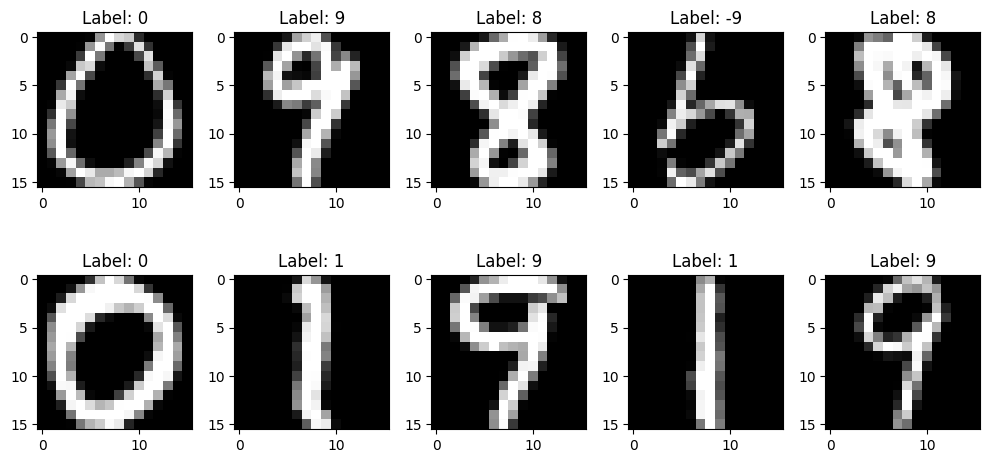

In [5]:
num_data = pd.read_csv('Numbers.txt', sep=' ')

labels_num = num_data.iloc[:, 0].values
pixels_num = num_data.iloc[:, 1:].values

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(pixels_num[i].reshape(16, 16), cmap='gray')
    ax.set_title(f'Label: {labels_num[i]}')
plt.tight_layout()
plt.show()

In [6]:
print("===== MNIST Dataset =====")
print(f"Number of samples: {len(labels_num)}")
print(f"Number of features per sample: {pixels_num.shape[1]} (flattened 16x16 = 256 pixels)")
print(f"Number of classes: {len(np.unique(labels_num))}")
print(f"Pixel value range: [{pixels_num.min()}, {pixels_num.max()}]")
print(f"Data type: {pixels_num.dtype}")
print("==================================")
print(f"Samples per class:\n{pd.Series(labels_num).value_counts().sort_index()}")
print("==================================")
class_counts = pd.Series(labels_num).value_counts().sort_index()
print(f"Class distribution (%):\n{(class_counts / len(labels_num) * 100).round(2)}")


===== MNIST Dataset =====
Number of samples: 2000
Number of features per sample: 256 (flattened 16x16 = 256 pixels)
Number of classes: 9
Pixel value range: [-1.0, 1.0]
Data type: float64
Samples per class:
-9    189
-2    221
 0    349
 1    307
 2    200
 5    186
 6    201
 8    168
 9    179
Name: count, dtype: int64
Class distribution (%):
-9     9.45
-2    11.05
 0    17.45
 1    15.35
 2    10.00
 5     9.30
 6    10.05
 8     8.40
 9     8.95
Name: count, dtype: float64


### Import cats and dogs data set

In [7]:
catdogdata = pd.read_csv('catdogdata.txt', sep=' ').values

labels_cd = np.zeros(catdogdata.shape[0])
labels_cd[99:] = 1

In [8]:
# print(f'Number of samples: {len(labels_cd)}')
# print(f'Number of features: {len(catdogdata[0])}')
# print(f'Number of classes: {len(set(labels_cd))}')
# print(f'Number of samples per class: {Counter(labels_cd)}')
# print(f'The range of pixel values: {catdogdata.min()} to {catdogdata.max()}')

print("===== Cats and Dogs Dataset =====")
print(f"Number of samples: {len(labels_cd)}")
print(f"Number of features per sample: {catdogdata.shape[1]} (flattened 64x64 = 4096 pixels)")
print(f"Number of classes: {len(np.unique(labels_cd))}")
print(f"Pixel value range: [{catdogdata.min()}, {catdogdata.max()}]")
print(f"Data type: {catdogdata.dtype}")
print("==================================")
print(f"Samples per class:\n{pd.Series(labels_cd).value_counts().sort_index()}")
print("==================================")
class_counts = pd.Series(labels_cd).value_counts().sort_index()
print(f"Class distribution (%):\n{(class_counts / len(labels_cd) * 100).round(2)}")

===== Cats and Dogs Dataset =====
Number of samples: 198
Number of features per sample: 4096 (flattened 64x64 = 4096 pixels)
Number of classes: 2
Pixel value range: [0, 255]
Data type: int64
Samples per class:
0.0    99
1.0    99
Name: count, dtype: int64
Class distribution (%):
0.0    50.0
1.0    50.0
Name: count, dtype: float64


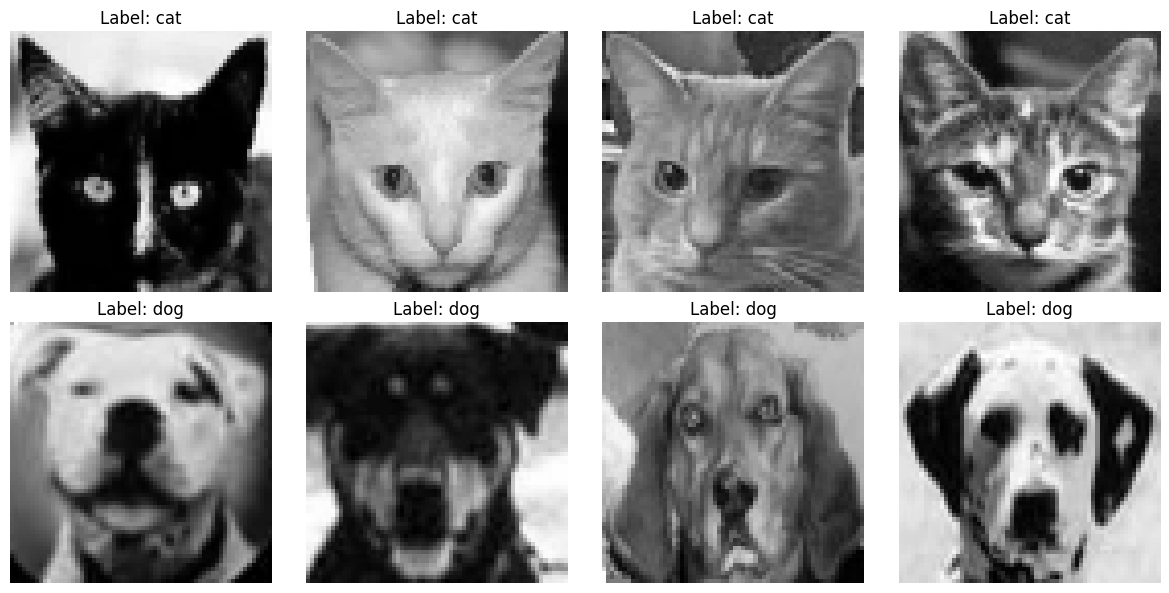

In [9]:
def rotateM(img):
    return np.rot90(img, k=-1)

np.random.seed(1000012)

ssc = np.random.choice(np.where(labels_cd == 0)[0], 4, replace=False) 
ssd = np.random.choice(np.where(labels_cd == 1)[0], 4, replace=False)


fig, axes = plt.subplots(2, 4, figsize=(12, 6))
label_list = ['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog']

for i, idx in enumerate([ssc[0], ssc[1], ssc[2], ssc[3], ssd[0], ssd[1], ssd[2], ssd[3]]):
    img = catdogdata[idx].reshape(64, 64)
    img = rotateM(img)
    ax = axes[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label_list[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Part 1: explore at least 3 different classifiers and at least two feature selection methods.

For this task, we use following 3 classifiers:

- SVM
- Logistic Regression
- Random Forest

Two selection methods:

- F-test
- Lasso


#### 1. Set classifiers for both data set


In [34]:
classifiers = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}




#### 2. Define the funtion for feature selection with F-test

In [31]:
# Helper function for feature selection and evaluation
def evaluate_classifier_with_feature_selection(clf, feature_range, data, labels, cv):
    best_score = 0
    best_k = 0
    best_features = None
    scores = []

    # data splitting
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    for k in feature_range:
        # Build pipeline: scaling -> feature selection -> classifier
            
        pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('selector', SelectKBest(score_func=f_classif, k=k)),
                ('classifier', clf)
            ])
    
        score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='balanced_accuracy').mean()
        scores.append((k, score))
        
        if score > best_score:
            best_score = score
            best_k = k

            pipeline.fit(x_train, y_train)
            seletor = pipeline.named_steps['selector']
            best_features = seletor.get_support(indices=True)
        
        print(f"Selected {k} features, Score: {score:.4f}")
        
        # Early stopping condition (optional)
        # if len(scores) > 100:
        #     recent_5_scores = [score for _, score in scores[-5:]]
        #     previous_5_scores = [score for _, score in scores[-10:-5]]
            
        #     if np.mean(recent_5_scores) <= np.mean(previous_5_scores):
        #         print("Early stopping due to no improvement.")
        #         break
    
    return best_score, best_k, scores, best_features


#### 3. Results


##### 3.1 Result for cats and dogs dataset


==== SVM ====
Selected 5 features, Score: 0.6954
Selected 105 features, Score: 0.7850
Selected 205 features, Score: 0.7908
Selected 305 features, Score: 0.8033
Selected 405 features, Score: 0.7971
Selected 505 features, Score: 0.8221
Selected 605 features, Score: 0.8287
Selected 705 features, Score: 0.8475
Selected 805 features, Score: 0.8600
Selected 905 features, Score: 0.8471
Selected 1005 features, Score: 0.8471
Selected 1105 features, Score: 0.8471
Selected 1205 features, Score: 0.8471
Selected 1305 features, Score: 0.8471
Selected 1405 features, Score: 0.8533
Selected 1505 features, Score: 0.8600
Selected 1605 features, Score: 0.8600
Selected 1705 features, Score: 0.8662
Selected 1805 features, Score: 0.8600
Selected 1905 features, Score: 0.8600
Selected 2005 features, Score: 0.8600
Selected 2105 features, Score: 0.8600
Selected 2205 features, Score: 0.8600
Selected 2305 features, Score: 0.8667
Selected 2405 features, Score: 0.8667
Selected 2505 features, Score: 0.8667
Selected 

e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected 2305 features, Score: 0.8217
Selected 2405 features, Score: 0.8283
Selected 2505 features, Score: 0.8346


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

Selected 2605 features, Score: 0.8346
Selected 2705 features, Score: 0.8346
Selected 2805 features, Score: 0.8346
Selected 2905 features, Score: 0.8346
Selected 3005 features, Score: 0.8346
Selected 3105 features, Score: 0.8346
Selected 3205 features, Score: 0.8408
Selected 3305 features, Score: 0.8346
Selected 3405 features, Score: 0.8408
Selected 3505 features, Score: 0.8413
Selected 3605 features, Score: 0.8413


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected 3705 features, Score: 0.8413
Selected 3805 features, Score: 0.8413


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected 3905 features, Score: 0.8350


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected 4005 features, Score: 0.8350

==== Random Forest ====
Selected 5 features, Score: 0.6388
Selected 105 features, Score: 0.7342
Selected 205 features, Score: 0.7838
Selected 305 features, Score: 0.7967
Selected 405 features, Score: 0.8221
Selected 505 features, Score: 0.8092
Selected 605 features, Score: 0.8408
Selected 705 features, Score: 0.8221
Selected 805 features, Score: 0.8217
Selected 905 features, Score: 0.8412
Selected 1005 features, Score: 0.8412
Selected 1105 features, Score: 0.8217
Selected 1205 features, Score: 0.8217
Selected 1305 features, Score: 0.8475
Selected 1405 features, Score: 0.8408
Selected 1505 features, Score: 0.8350
Selected 1605 features, Score: 0.8162
Selected 1705 features, Score: 0.8408
Selected 1805 features, Score: 0.7967
Selected 1905 features, Score: 0.8538
Selected 2005 features, Score: 0.8083
Selected 2105 features, Score: 0.8025
Selected 2205 features, Score: 0.8533
Selected 2305 features, Score: 0.8083
Selected 2405 features, Score: 0.8146

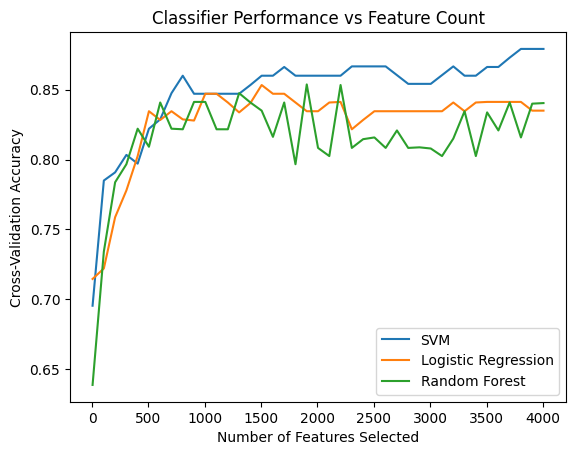

In [35]:
# Cross-validation to determine the best number of features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_range = np.arange(5, 4096, 100)

results = {}

for clf_name, clf in classifiers.items():
    
    print(f"\n==== {clf_name} ====")
    
    # Evaluate classifier using forward feature selection
    best_score, best_k, scores, _ = evaluate_classifier_with_feature_selection(clf, feature_range, catdogdata, labels_cd, cv)
    
    # Store the best results for each classifier
    results[clf_name] = {"best_score": best_score, "best_k": best_k, "scores": scores}


print("\n==== Best Results ====")
for clf_name in classifiers:
    print(f"{clf_name}: Best Accuracy = {results[clf_name]['best_score']:.4f} with k = {results[clf_name]['best_k']}")

# Plot the feature vs accuracy graph for each classifier
for clf_name, result in results.items():
    feature_counts = [k for k, _ in result['scores']]
    accuracies = [score for _, score in result['scores']]
    
    plt.plot(feature_counts, accuracies, label=clf_name)

plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.title('Classifier Performance vs Feature Count')
plt.show()

##### 3.2 Result for MNIST dataset


==== SVM ====
Selected 5 features, Score: 0.5097
Selected 10 features, Score: 0.6580
Selected 15 features, Score: 0.7057
Selected 20 features, Score: 0.7387
Selected 25 features, Score: 0.7766
Selected 30 features, Score: 0.8058
Selected 35 features, Score: 0.8192
Selected 40 features, Score: 0.8240
Selected 45 features, Score: 0.8415
Selected 50 features, Score: 0.8435
Selected 55 features, Score: 0.8559
Selected 60 features, Score: 0.8600
Selected 65 features, Score: 0.8671
Selected 70 features, Score: 0.8760
Selected 75 features, Score: 0.8769
Selected 80 features, Score: 0.8811
Selected 85 features, Score: 0.8824
Selected 90 features, Score: 0.8842
Selected 95 features, Score: 0.8873
Selected 100 features, Score: 0.8911
Selected 105 features, Score: 0.8906
Selected 110 features, Score: 0.8892
Selected 115 features, Score: 0.8945
Selected 120 features, Score: 0.8988
Selected 125 features, Score: 0.9015
Selected 130 features, Score: 0.8996
Selected 135 features, Score: 0.9024
Select

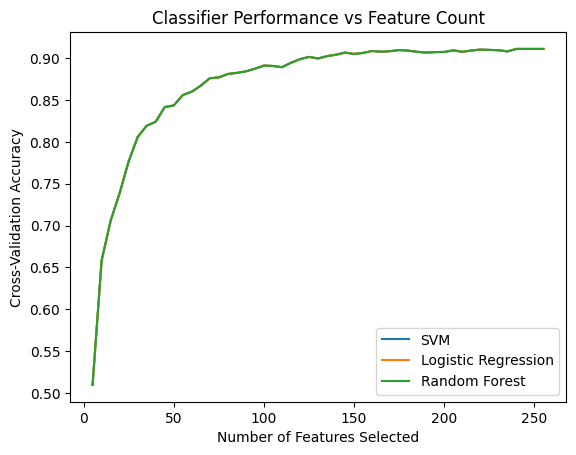

In [29]:
# Cross-validation to determine the best number of features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_range = np.arange(5, pixels_num.shape[1], 5)

results = {}

for clf_name, clf in classifiers.items():
    
    print(f"\n==== {clf_name} ====")
    
    # Evaluate classifier using forward feature selection
    best_score, best_k, scores, _ = evaluate_classifier_with_feature_selection(clf, feature_range, pixels_num, labels_num, cv)
    
    # Store the best results for each classifier
    results[clf_name] = {"best_score": best_score, "best_k": best_k, "scores": scores}


print("\n==== Best Results ====")
for clf_name in classifiers:
    print(f"{clf_name}: Best Accuracy = {results[clf_name]['best_score']:.4f} with k = {results[clf_name]['best_k']}")

# Plot the feature vs accuracy graph for each classifier
for clf_name, result in results.items():
    feature_counts = [k for k, _ in result['scores']]
    accuracies = [score for _, score in result['scores']]
    
    plt.plot(feature_counts, accuracies, label=clf_name)

plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.title('Classifier Performance vs Feature Count')
plt.show()

In [24]:
num_repeats = 10

heatmaps_num = {clf_name: np.zeros((num_repeats, pixels_num.shape[1])) for clf_name in classifiers}
heatmaps_cd = {clf_name: np.zeros((num_repeats, catdogdata.shape[1])) for clf_name in classifiers}

In [33]:
print(heatmaps_cd['SVM'][0].shape)

(4096,)


In [47]:

best_scores_num = {clf_name: [] for clf_name in classifiers}
best_k_num = {clf_name: [] for clf_name in classifiers}
best_scores_cd = {clf_name: [] for clf_name in classifiers}
best_k_cd = {clf_name: [] for clf_name in classifiers}

for run in range(num_repeats):
    print(f"\n ==== Run {run + 1} ====")

    for clf_name, clf in classifiers.items():
        print(f"\n==== {clf_name} ====")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Evaluate classifier using forward feature selection
        feature_range = np.arange(5, pixels_num.shape[1], 5)
        best_score_num, best_k_num, scores_num, best_feature_num = evaluate_classifier_with_feature_selection(clf, feature_range, pixels_num, labels_num, cv)
        
        best_scores_num[clf_name].append(best_score_num)
        best_k_num[clf_name].append(best_k_num)

        # heatmaps_num[clf_name][run] = best_feature_num
        for feat in best_feature_num:
                    heatmaps_num[clf_name][run][feat] += 1

        heatmap_image = heatmaps_num[clf_name][run].reshape(16, 16)
        plt.figure(figsize=(6, 6))
        plt.imshow(heatmap_image, cmap='hot')
        # plt.colorbar(label=f'Selected Count (out of {num_repeats * cv})')
        plt.title(f"{clf_name} - Feature Selection Heatmap (run={run + 1})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        feature_range = np.arange(100, catdogdata.shape[1], 200)
        best_score_cd, best_k_cd, scores_cd, best_feature_cd = evaluate_classifier_with_feature_selection(clf, feature_range, catdogdata, labels_cd, cv)

        best_scores_cd[clf_name].append(best_score_cd)
        best_k_cd[clf_name].append(best_k_cd)

        for feat in best_feature_cd:
                    heatmaps_cd[clf_name][run][feat] += 1

        heatmap_image = heatmaps_cd[clf_name][run].reshape(64, 64)
        plt.figure(figsize=(6, 6))
        plt.imshow(heatmap_image, cmap='hot')
        # plt.colorbar(label=f'Selected Count (out of {num_repeats * cv})')
        plt.title(f"{clf_name} - Feature Selection Heatmap (run={run + 1})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    
# Print the best results for each classifier
print("\n==== Best Results ====")
for clf_name in classifiers:
    print(f"{clf_name}: Best Accuracy = {np.mean(best_scores_cd[clf_name]):.4f} with k = {np.mean(best_k_cd[clf_name])}")
    print(f"{clf_name}: Best Accuracy = {np.mean(best_scores_num[clf_name]):.4f} with k = {np.mean(best_k_num[clf_name])}")





 ==== Run 1 ====

==== SVM ====
Selected 5 features, Score: 0.5805
Selected 10 features, Score: 0.7270
Selected 15 features, Score: 0.7785
Selected 20 features, Score: 0.8180
Selected 25 features, Score: 0.8535
Selected 30 features, Score: 0.8720
Selected 35 features, Score: 0.8805
Selected 40 features, Score: 0.8880
Selected 45 features, Score: 0.8940
Selected 50 features, Score: 0.9000
Selected 55 features, Score: 0.9065
Selected 60 features, Score: 0.9135
Selected 65 features, Score: 0.9165
Selected 70 features, Score: 0.9200
Selected 75 features, Score: 0.9235
Selected 80 features, Score: 0.9245
Selected 85 features, Score: 0.9280
Selected 90 features, Score: 0.9285
Selected 95 features, Score: 0.9295
Selected 100 features, Score: 0.9315
Selected 105 features, Score: 0.9335
Selected 110 features, Score: 0.9320
Selected 115 features, Score: 0.9340
Selected 120 features, Score: 0.9365
Selected 125 features, Score: 0.9340


KeyboardInterrupt: 

#### 4. Define the funtion for feature selection with lasso

In [8]:
def evaluate_classifier_with_lasso_cv(clf, data, labels, alpha_range, cv):

    pipeline = Pipeline([
        ('selector', SelectFromModel(Lasso(random_state=42))),
        ('classifier', clf)
    ])

    param_grid = {'selector__estimator__alpha': alpha_range}

    grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
    grid_search.fit(data, labels)

    best_alpha = grid_search.best_params_['selector__estimator__alpha']
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_
    selector = best_model.named_steps['selector']
    selected_features = selector.get_support(indices=True)

    print(f"Best Alpha: {best_alpha}, Selected Features: {len(selected_features)}, Best Score: {best_score:.4f}")
    return best_alpha, best_score, selected_features

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
alpha_range = np.logspace(-3, 0, 20)

for clf_name, clf in classifiers.items():
    print(f"\n==== {clf_name} ====")
    best_alpha, best_score, selected_features = evaluate_classifier_with_lasso_cv(clf, pixels_num, labels_num, alpha_range, cv)
    print(f"Classifier: {clf_name}, Best Alpha: {best_alpha}, Best Score: {best_score:.4f}, Selected Features: {len(selected_features)}")


==== SVM ====
Best Alpha: 0.001, Selected Features: 236, Best Score: 0.9435
Classifier: SVM, Best Alpha: 0.001, Best Score: 0.9435, Selected Features: 236

==== Logistic Regression ====
Best Alpha: 0.00206913808111479, Selected Features: 215, Best Score: 0.9220
Classifier: Logistic Regression, Best Alpha: 0.00206913808111479, Best Score: 0.9220, Selected Features: 215

==== Random Forest ====
Best Alpha: 0.002976351441631319, Selected Features: 207, Best Score: 0.9340
Classifier: Random Forest, Best Alpha: 0.002976351441631319, Best Score: 0.9340, Selected Features: 207


In [11]:
for clf_name, clf in classifiers.items():
    print(f"\n==== {clf_name} ====")
    best_alpha, best_score, selected_features = evaluate_classifier_with_lasso_cv(clf, catdogdata, labels_cd, alpha_range, cv)
    print(f"Classifier: {clf_name}, Best Alpha: {best_alpha}, Best Score: {best_score:.4f}, Selected Features: {len(selected_features)}")


==== SVM ====


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.474e-02, tolerance: 4.950e-03
  model = cd_fast.enet_coordinate_descent(


Best Alpha: 0.008858667904100823, Selected Features: 438, Best Score: 0.8935
Classifier: SVM, Best Alpha: 0.008858667904100823, Best Score: 0.8935, Selected Features: 438

==== Logistic Regression ====


e:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.474e-02, tolerance: 4.950e-03
  model = cd_fast.enet_coordinate_descent(


Best Alpha: 0.008858667904100823, Selected Features: 438, Best Score: 0.8432
Classifier: Logistic Regression, Best Alpha: 0.008858667904100823, Best Score: 0.8432, Selected Features: 438

==== Random Forest ====
Best Alpha: 0.3359818286283781, Selected Features: 145, Best Score: 0.8578
Classifier: Random Forest, Best Alpha: 0.3359818286283781, Best Score: 0.8578, Selected Features: 145
